In [8]:
import torch
import torch as th
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader

from model import Generator, Discriminator, gradient_penalty
from utils import Transformed_PolyGraphDataset, CATEGORY_DICT

import numpy as np
import time
from dotenv import load_dotenv
from pathlib import Path
import os

# Load paths

In [9]:
load_dotenv()
SWISS_DWELLING_ROOT = Path(os.getenv("SWISS_DWELLING_ROOT"))
SAVED_MODELS_ROOT = Path(os.getenv("SAVED_MODELS_ROOT"))

GENERATOR_PATH = SAVED_MODELS_ROOT / "generator.pt"
DISCRIMINATOR_PATH = SAVED_MODELS_ROOT / "discriminator.pt"

In [10]:
SWISS_DWELLING_ROOT, SAVED_MODELS_ROOT, GENERATOR_PATH, DISCRIMINATOR_PATH

(WindowsPath('D:graph-ml/swiss-dwellings-v3.0.0'),
 WindowsPath('D:graph-ml/saved-models'),
 WindowsPath('D:graph-ml/saved-models/generator.pt'),
 WindowsPath('D:graph-ml/saved-models/discriminator.pt'))

# GPU acceleration

In [11]:
# Check if cuda is available
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print('Using device:', device)
device = 'cpu'
# available devices
print(th.cuda.device_count())

Using device: cuda
1


# Hyperparameters


In [12]:
""" 
Hyperparameters
"""

MAX_POLYGONS = 30       # max nr. of polygons to output

# Optimizer params
g_lr = 0.001 
d_lr = 0.001
b1 = 0.5 
b2 = 0.999  

# WGAN params
N_critic = 5            # nr of times to train discriminator more
lambda_gp = 10          # gradient penalty hyperpraram

# Training params
MAX_EPOCHS = 50
BATCH_SIZE = 32

# Network parameters
NOISE_SIZE = 128
HIDDEN_GENERATOR = [128, 128, 64, 32, 32]                 # list of dimensions for hidden layers
OUTPUT_GENERATOR = MAX_POLYGONS * 2             # we want to output at most this many polygons per node (note [x1... y1...] format)

HIDDEN_DISCRIMINATOR = [128, 128, 64, 32, 16]

# Model definition

### Generator
- Input of Generator will always be: "noise size + Nr. of categories" 
- Output of Generator = (MAX_POYLGONS * 2) due to our output coordinate format


### Discriminator
- Input of Discriminator = output of Generator (MAX_POLYGONS * 2) due to our output coordinate format
- Output of Discriminator will always be 1

In [13]:
""" 
Model Definitions
"""
generator = Generator(input_dim=NOISE_SIZE + len(CATEGORY_DICT), 
                      output_dim=OUTPUT_GENERATOR, 
                      hidden_dims=HIDDEN_GENERATOR, device=device)

discriminator = Discriminator(input_dim=OUTPUT_GENERATOR, 
                              hidden_dims=HIDDEN_DISCRIMINATOR, device=device)

# Move models to GPU or cpu
generator.to(device)
discriminator.to(device)

print(generator.module_list)
print(discriminator.module_list)

ModuleList(
  (0): TAGConv(141, 128, K=3)
  (1): TAGConv(128, 128, K=3)
  (2): TAGConv(128, 64, K=3)
  (3): TAGConv(64, 32, K=3)
  (4): TAGConv(32, 60, K=3)
)
ModuleList(
  (0): TAGConv(60, 128, K=3)
  (1): TAGConv(128, 128, K=3)
  (2): TAGConv(128, 64, K=3)
  (3): TAGConv(64, 32, K=3)
  (4): TAGConv(32, 16, K=3)
  (5): Linear(in_features=16, out_features=1, bias=True)
)


In [14]:
# Optimizers
optimizer_G = th.optim.Adam(generator.parameters(), lr=g_lr, betas=(b1, b2)) 
optimizer_D = th.optim.Adam(discriminator.parameters(), lr=d_lr, betas=(b1, b2))

# Training loop

Generator details:
- We generate a noise vector
- Generator uses noise vector and training data (the categories) as input
- Generator uses graph NN layers to generate coordinates out of the noise vectors using the graph structure and categories
- Generator output: (MAX_POLYGONS * 2) for each node in the input

Discriminator details:
- Generate discriminator output (score) for real data and fake (generated) data
- Compute loss over these scores with additional gradient penalty loss

In [15]:
def run_epoch(generator, discriminator, optimizer_g, optimizer_d, data_loader):

    losses_g, losses_d = [], []
    num_steps = 0

    # real = batch of Data() ex. [Data(), Data(), ...] is 1 batch
    start_time = time.time()
    for i, real in enumerate(data_loader):
        num_steps += 1

        # Input noise_data into generator            
        noise = th.randn((len(real.category), NOISE_SIZE)).to(device)
        fake = generator(real, noise)

        # fake.shape = (batch_size * nodes, output_features = 60)
        # We must turn this into appropriate (batch) input for the discriminator
        fake = Batch(geometry=fake, edge_index=real.edge_index, batch=real.batch)

        discriminator_fake = discriminator(fake)    # discriminator scores for fakes
        discriminator_real = discriminator(real)    # discriminator scores for reals
        
        gp = gradient_penalty(discriminator, real, fake)

        # Discriminator loss and train
        loss_discriminator = -(th.mean(discriminator_real) - th.mean(discriminator_fake)) + lambda_gp * gp
        
        discriminator.zero_grad() 
        loss_discriminator.backward() 
        optimizer_d.step()

        losses_d.append(loss_discriminator.item())

        # Only train Generator every 5 steps
        if num_steps % N_critic == 0:
            noise_g = th.randn((len(real.category), NOISE_SIZE))
            fake_g = generator(real, noise_g) 
            fake_g = Batch(geometry=fake_g, edge_index=real.edge_index, batch=real.batch)

            output = discriminator(fake_g).reshape(-1)      # discriminator scores for fake
            loss_generator = -th.mean(output)               # loss for genereator = the discriminators' judgement
                                                            # higher score = better
            generator.zero_grad()
            loss_generator.backward()
            optimizer_g.step()

            losses_g.append(loss_generator.item())
        
        # 49 is just a temporary number
        if i % 49 == 0:
            batch_time = time.time() - start_time
            print("Batch {} took {:.2f} seconds.".format(i, batch_time))
    
    return sum(losses_g) / len(losses_g), sum(losses_d) / len(losses_d)

# Main training loop

Code could be improved. Make sure to specify your own 'generator_path', 'discriminator_path'.

In [16]:
# Main training loop
def train(generator, discriminator, optimizer_g, optimizer_d, data_loader, max_epochs):
    start_time = time.time() 
    losses_g, losses_d = [], []

    for epoch in range(1, max_epochs + 1):
        epoch_time = time.time() 

        loss_g, loss_d = run_epoch(generator, discriminator, optimizer_g, optimizer_d, data_loader)
        losses_g.append(loss_g)
        losses_d.append(loss_d)

        # TODO: Evaluation and logging code??
        epoch_time = time.time() - epoch_time 
        total_time = time.time() - start_time
        print("Total runtime: {:.2f}, Epoch: {}, took: {:.2f} seconds, loss_g: {:.2f}, loss_d: {:.2f}".format(total_time, epoch, epoch_time, loss_g, loss_d))

        # save model every 10 epochs
        if epoch % 10:
            print("Saving model at epoch {}".format(epoch))
            # generator_path = r'C:\School\DELFT\Graph_ML_project\saved_models\generator.pt'
            # discriminator_path = r'C:\School\DELFT\Graph_ML_project\saved_models\discriminator.pt'
            th.save(generator.state_dict(), GENERATOR_PATH)
            th.save(discriminator.state_dict(), DISCRIMINATOR_PATH)

    return losses_g, losses_d

# Training code

In [17]:
#path = r'D:swiss-dwelling\swiss-dwellings-v3.0.0'
dataset = Transformed_PolyGraphDataset(SWISS_DWELLING_ROOT)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
n_batches = len(dataloader)
print(n_batches)

losses_g, losses_d = train(generator, discriminator, optimizer_G, optimizer_D, dataloader, max_epochs=100)

294
Batch 0 took 2.05 seconds.
Batch 49 took 78.88 seconds.
Batch 98 took 146.37 seconds.
Batch 147 took 208.58 seconds.
Batch 196 took 267.51 seconds.
Batch 245 took 322.46 seconds.
Total runtime: 375.44, Epoch: 1, took: 375.44 seconds, loss_g: -163.83, loss_d: -5001.01
Saving model at epoch 1
Batch 0 took 0.20 seconds.
Batch 49 took 12.70 seconds.
Batch 98 took 24.40 seconds.
Batch 147 took 36.58 seconds.
Batch 196 took 48.74 seconds.
Batch 245 took 60.07 seconds.
Total runtime: 446.52, Epoch: 2, took: 71.03 seconds, loss_g: -132.62, loss_d: -3334.53
Saving model at epoch 2
Batch 0 took 0.26 seconds.
Batch 49 took 11.88 seconds.
Batch 98 took 23.94 seconds.
Batch 147 took 35.73 seconds.
Batch 196 took 47.50 seconds.
Batch 245 took 59.28 seconds.
Total runtime: 517.54, Epoch: 3, took: 70.99 seconds, loss_g: -267.62, loss_d: -2163.12
Saving model at epoch 3
Batch 0 took 0.24 seconds.
Batch 49 took 12.28 seconds.
Batch 98 took 23.98 seconds.
Batch 147 took 35.71 seconds.
Batch 196 took 

# Generator output code

The following section contains code to generate the coordinates for a floorplan using the generator.

requires:
- graph 
- categories per node (room)
- noise vector (of size: NOISE_SIZE)

In [27]:
# Load model
model_g_path = GENERATOR_PATH #r'C:\School\DELFT\Graph_ML_project\saved_models\generator.pt'

# Make sure the model you're loading in is consistent with the size of your model
generator = Generator(input_dim=NOISE_SIZE + len(CATEGORY_DICT), 
                      output_dim=OUTPUT_GENERATOR, 
                      hidden_dims=HIDDEN_GENERATOR)

generator.load_state_dict(th.load(model_g_path))
print(generator)

Generator(
  (module_list): ModuleList(
    (0): TAGConv(141, 64, K=3)
    (1): TAGConv(64, 32, K=3)
    (2): TAGConv(32, 60, K=3)
  )
)


In [23]:
# Generate floorplan
#path = r'C:\School\DELFT\Graph_ML_project\data\swiss-dwellings-v3.0.0'
dataset = Transformed_PolyGraphDataset(SWISS_DWELLING_ROOT)

data = dataset[0]
print(data)

noise_vector = th.randn((data.num_nodes, NOISE_SIZE))
output = generator(data, noise_vector)
print(output.shape)

output_data = Data(edge_index=data.edge_index, geometry=output, category=data.category, num_nodes=data.num_nodes)
print(output_data)

Data(edge_index=[2, 72], geometry=[42, 60], category=[42, 13], num_nodes=42)
torch.Size([42, 60])
Data(edge_index=[2, 72], geometry=[42, 60], category=[42, 13], num_nodes=42)


In [24]:
# Visualize floorplan
# use output_data = Data(edge_index, geometry, category, num_nodes)

In [22]:
import matplotlib.pyplot as plt

In [16]:
plt.plot(losses_g)
plt.plot(losses_d)

NameError: name 'losses_g' is not defined

In [10]:
plt.plot([loss_d.detach() for loss_d in losses_d])
plt.plot([loss_d.detach() for loss_d in losses_g])


NameError: name 'losses_d' is not defined

In [2]:
# regex parse output.txt with "([0-9-.]*)\sseconds,\sloss_g:\s([0-9-.]*),\sloss_d:\s([0-9-.]*)" where index 0 is the time it took, index 1 is loss_g, index 2 is loss_d
import re

with open('output2.txt', 'r') as f:
    lines = f.readlines()

times = []
losses_g = []
losses_d = []

for line in lines:
    match = re.search("([0-9-.]*)\sseconds,\sloss_g:\s([0-9-.]*),\sloss_d:\s([0-9-.]*)", line)
    if match:
        times.append(float(match.group(1)))
        losses_g.append(float(match.group(2)))
        losses_d.append(float(match.group(3)))


Text(0, 0.5, 'Loss')

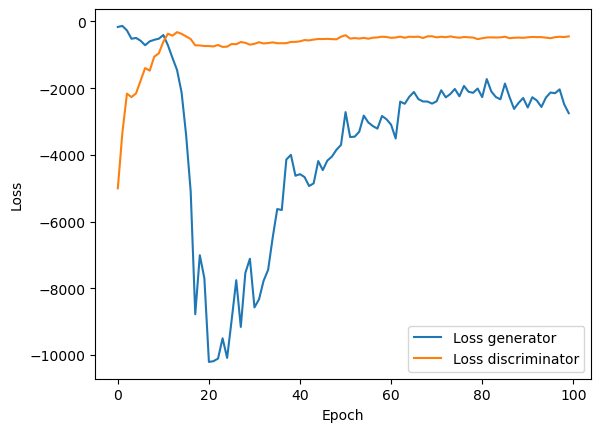

In [5]:
plt.plot(losses_g)
plt.plot(losses_d)
plt.legend(['Loss generator', 'Loss discriminator'])
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Time (s)')

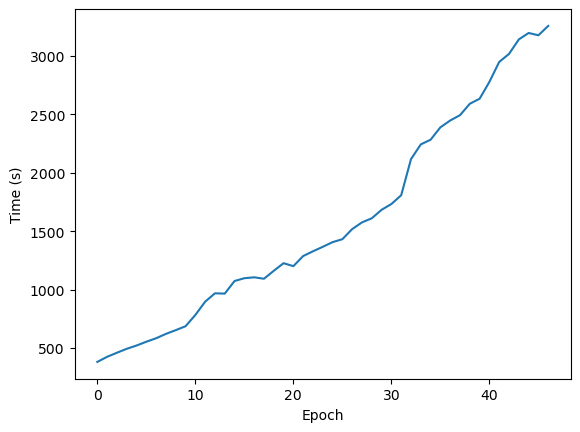

In [8]:
plt.plot(times)
plt.xlabel("Epoch")
plt.ylabel("Time (s)")

In [20]:
len(losses_d)

100

In [17]:
generator.load_state_dict(th.load(SAVED_MODELS_ROOT / "generator-big-e100.pt"))

<All keys matched successfully>

In [18]:
generator.eval()

Generator(
  (module_list): ModuleList(
    (0): TAGConv(141, 128, K=3)
    (1): TAGConv(128, 128, K=3)
    (2): TAGConv(128, 64, K=3)
    (3): TAGConv(64, 32, K=3)
    (4): TAGConv(32, 60, K=3)
  )
)

NameError: name 'data' is not defined